In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

In [9]:
df = pd.read_csv('data/equity_energy_weekly.csv')

### Random split model ###

Data pre-processing

In [12]:
# -----------------------
# Handling Missing Values
# -----------------------

# Since we used an inner join, missing values should be minimal, but verify
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# If any missing values exist, decide on a strategy. Here, we'll drop them.
df_clean = df.dropna()

print("\nAfter Handling Missing Values:")
print(df_clean.isnull().sum())

# -----------------------
# Convert date and exclude pre ETS phase 3 data
# -----------------------

# Convert 'date' column to datetime (if not already)
df['date'] = pd.to_datetime(df['date'], dayfirst=False)

# Sort by date in ascending order
df = df.sort_values('date')

# Compute log returns for selected columns
for col in ['eu_ets', 'brent_crude', 'euronext100', 'ngh', 'rot_coal']:
    df[col] = np.log(df[col]) - np.log(df[col].shift(1))

# Drop any NaNs from shifting
df = df.dropna()

print("\nAfter Log Return Transform:")
print(df.head())


Missing Values in Each Column:
date           0
eu_ets         0
brent_crude    0
euronext100    0
ngh            0
rot_coal       0
pow_dem_AUT    0
pow_dem_BEL    0
pow_dem_BGR    0
pow_dem_CHE    0
pow_dem_CZE    0
pow_dem_DEU    0
pow_dem_DNK    0
pow_dem_ESP    0
pow_dem_EST    0
pow_dem_FIN    0
pow_dem_FRA    0
pow_dem_GBR    0
pow_dem_GRC    0
pow_dem_HRV    0
pow_dem_HUN    0
pow_dem_ITA    0
pow_dem_LTU    0
pow_dem_LUX    0
pow_dem_LVA    0
pow_dem_MNE    0
pow_dem_NLD    0
pow_dem_NOR    0
pow_dem_POL    0
pow_dem_PRT    0
pow_dem_ROU    0
pow_dem_SVK    0
pow_dem_SVN    0
pow_dem_SWE    0
dtype: int64

After Handling Missing Values:
date           0
eu_ets         0
brent_crude    0
euronext100    0
ngh            0
rot_coal       0
pow_dem_AUT    0
pow_dem_BEL    0
pow_dem_BGR    0
pow_dem_CHE    0
pow_dem_CZE    0
pow_dem_DEU    0
pow_dem_DNK    0
pow_dem_ESP    0
pow_dem_EST    0
pow_dem_FIN    0
pow_dem_FRA    0
pow_dem_GBR    0
pow_dem_GRC    0
pow_dem_HRV    0
pow_d

Model spec and execution


Features Head:
   brent_crude  euronext100       ngh  rot_coal  pow_dem_AUT  pow_dem_BEL  \
1    -0.110882    -0.009859 -0.025880 -0.078826     7.544132    11.308632   
2    -0.046639     0.035645  0.065528 -0.036905     6.855185    11.738174   
3    -0.000992     0.050505 -0.069896 -0.042946     7.111723    11.404311   
4     0.032464     0.014773 -0.037230  0.025884     7.884554    11.702229   
5     0.150332     0.010906 -0.049901  0.045864     7.936390    11.303735   

   pow_dem_BGR  pow_dem_CHE  pow_dem_CZE  pow_dem_DEU  ...  pow_dem_LVA  \
1     5.325464     8.067851     8.111988    61.733801  ...     0.898512   
2     5.030595     8.354589     8.265440    63.052533  ...     0.934679   
3     5.091113     8.430060     8.345863    62.747558  ...     0.913643   
4     5.052982     8.638911     8.531786    63.909561  ...     0.921149   
5     5.395077     8.391774     8.327089    62.714280  ...     0.902268   

   pow_dem_MNE  pow_dem_NLD  pow_dem_NOR  pow_dem_POL  pow_dem_PRT  \


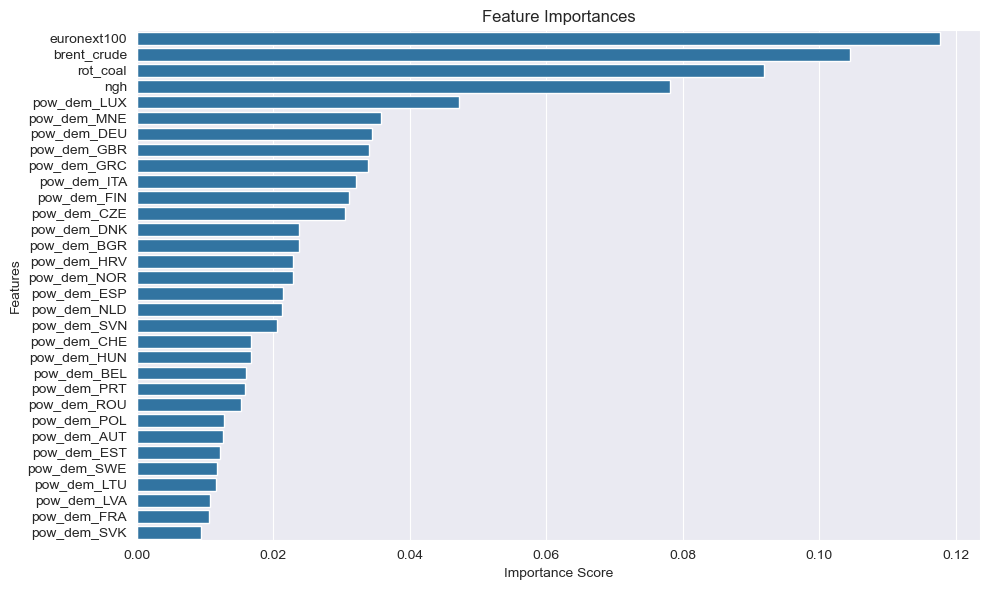

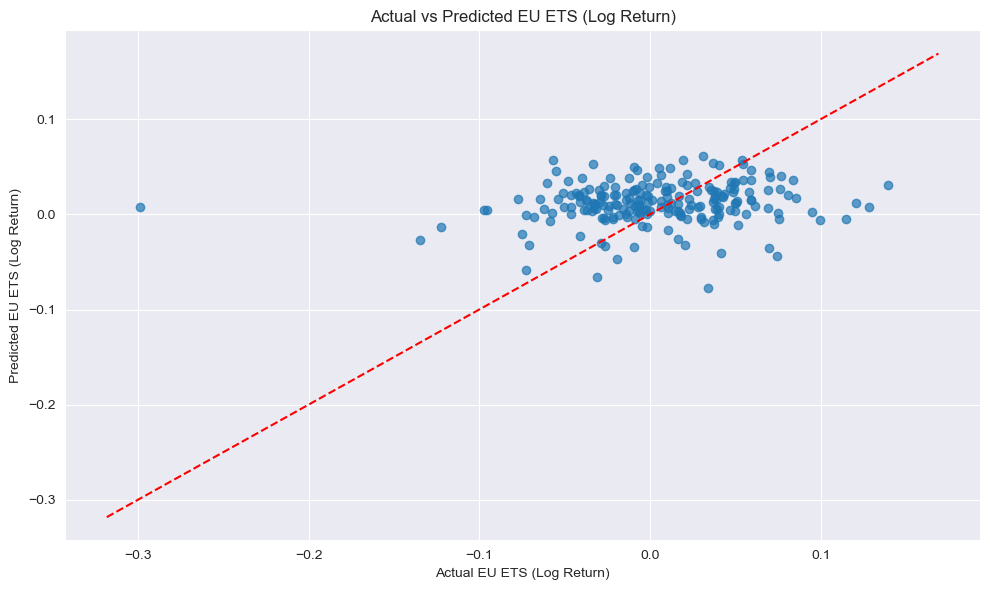


Model saved as 'random_forest_eu_ets_model.pkl'


In [13]:
# -----------------------------------------
# Define Features and Target
# -----------------------------------------

feature_columns = [
    c for c in df.columns
    if c not in ('date', 'eu_ets')  # Exclude date and target from features
]

target_column = 'eu_ets'

X = df[feature_columns]
y = df[target_column]

print("\nFeatures Head:")
print(X.head())

print("\nTarget Head (Log Return of eu_ets):")
print(y.head())

# Choose a cutoff date for final out-of-sample test
cutoff_date = '2021-01-01'

# Split into train (before cutoff) and test (on/after cutoff)
train_df = df[df['date'] < cutoff_date].copy()
test_df  = df[df['date'] >= cutoff_date].copy()

X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_test  = test_df[feature_columns]
y_test  = test_df[target_column]

print(f"\nTraining set: {X_train.shape[0]} rows")
print(f"Test set:     {X_test.shape[0]} rows")


# Initialize TimeSeriesSplit
# n_splits is how many "folds" you want
tscv = TimeSeriesSplit(n_splits=5)

# Initialize RandomForest
rf = RandomForestRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,                         # Use TimeSeriesSplit instead of a fixed integer
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

print("\nStarting Grid Search (TimeSeriesSplit) for Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Best estimator
best_rf = grid_search.best_estimator_

# Make final predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nTime-based Test Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 ): {r2:.4f}")

# -------------------------------------------------
# Plot Feature Importances, Predictions
# -------------------------------------------------
importances = best_rf.feature_importances_
feature_importances = pd.Series(importances, index=feature_columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual EU ETS (Log Return)')
plt.ylabel('Predicted EU ETS (Log Return)')
plt.title('Actual vs Predicted EU ETS (Log Return)')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(best_rf, 'random_forest_eu_ets_model.pkl')
print("\nModel saved as 'random_forest_eu_ets_model.pkl'")

Correlation matrix

In [15]:
# Calculate correlation matrix (by default, .corr() uses Pearson's correlation)
corr_matrix = df.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                 date    eu_ets  brent_crude  euronext100       ngh  rot_coal  \
date         1.000000 -0.002938     0.005545     0.000889  0.013827 -0.008433   
eu_ets      -0.002938  1.000000     0.135415     0.244382  0.082047  0.003438   
brent_crude  0.005545  0.135415     1.000000     0.391280  0.109710  0.161264   
euronext100  0.000889  0.244382     0.391280     1.000000  0.058532 -0.067195   
ngh          0.013827  0.082047     0.109710     0.058532  1.000000  0.168383   
rot_coal    -0.008433  0.003438     0.161264    -0.067195  0.168383  1.000000   
pow_dem_AUT -0.156921 -0.047169     0.025081     0.013461 -0.149389 -0.028840   
pow_dem_BEL -0.393520 -0.015800     0.046384     0.033481 -0.119281 -0.042649   
pow_dem_BGR -0.067895 -0.050016    -0.017840     0.023119 -0.182358 -0.025647   
pow_dem_CHE -0.089898 -0.029716     0.017311     0.026259 -0.184917 -0.073124   
pow_dem_CZE -0.169109 -0.031520     0.013692     0.030719 -0.128531 -0.039025   
pow_dem_

Correlation matrix heatmap

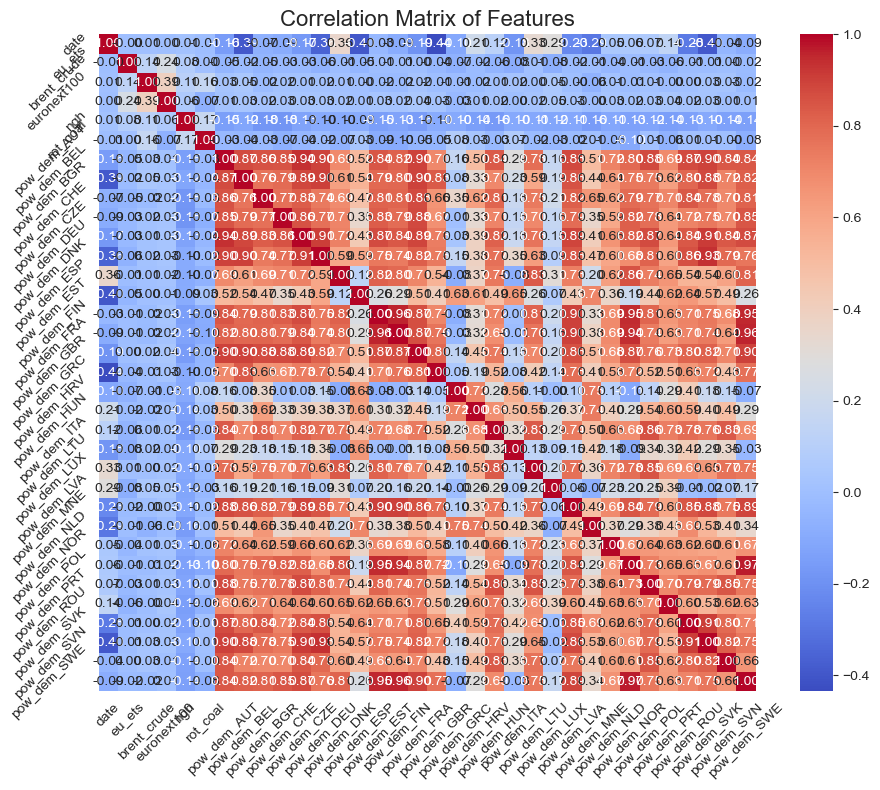

In [16]:
plt.figure(figsize=(20, 20))  # Adjust the figure size to your preference

# Create a heatmap
sns.heatmap(corr_matrix,
            annot=True,      # Display the correlation values in each cell
            cmap='coolwarm', # Color map style
            fmt=".2f",       # Format to display correlation values (2 decimal places)
            square=True      # Makes each cell square-shaped
           )

plt.title('Correlation Matrix of Features', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.yticks(rotation=45)
plt.tight_layout()       # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()